## Introduction
In this notebook we will 

(1) Handle outliers,

(2) Engineer features and

(3) Select the best features.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
data_path = "/home/akhilesh/DataScience/FlightPricePrediction/cleaned_data2.csv"
data = pd.read_csv(data_path,index_col=['Unnamed: 0'])
data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Price,Arrival_Hour,Arrival_Day,Arrival_Min,Dep_Hour,Dep_Day,Dep_Min,Journey_Day,Journey_Month,Journey_Year,Journey_DOW,Dep_HourOfDay
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,170,0,3897,1,22,10,22,24,20,24,3,2019,6,Night
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2,7662,13,18,15,5,5,50,5,1,2019,5,Early Morning


### Outlier Treatment (IQR Method)

We classify a data point(price) as an outlier if it lies below the limit (IQR -3xIQR)  or above (IQR + 3xIQR). After identifying, we replace them with the median value. This is done because we assume that the prices are normally distributed around the median.

<AxesSubplot:>

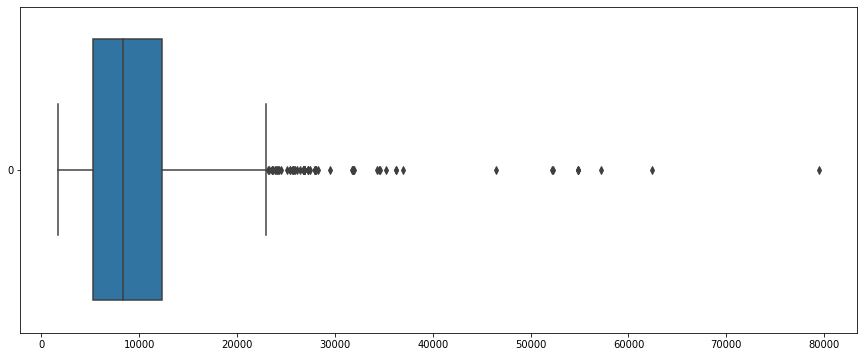

In [4]:
Fig=plt.figure(figsize=(15,6))
sns.boxplot(data['Price'],orient='h')

In [5]:
q1=data['Price'].quantile(0.25)
q3=data['Price'].quantile(0.75)

iqr=q3 - q1
max_out=q3 + 3*iqr
min_out=q3 - 3*iqr
print(min_out,max_out)

-8915.0 33661.0


In [6]:
print(len([price for price in data['Price'] if price> max_out or price<min_out]))

16


Replacing values..

In [7]:
data['Price'] = np.where(data['Price']>=max_out , data['Price'].median() , data['Price'])

### Feature Engineering 
We will perform One-Hot Encoding for Source and Targeted Guided Encoding for Destination and Airline. No inbuild function will be used in order to demostrate what is happening 'Behind the Scene'.

In [8]:
data.head(2)
data['Destination'].unique()

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Price,Arrival_Hour,Arrival_Day,Arrival_Min,Dep_Hour,Dep_Day,Dep_Min,Journey_Day,Journey_Month,Journey_Year,Journey_DOW,Dep_HourOfDay
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,170,0,3897.0,1,22,10,22,24,20,24,3,2019,6,Night
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2,7662.0,13,18,15,5,5,50,5,1,2019,5,Early Morning


array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

In [9]:
#One Hot encoding for Flight Source.

for sub_category in data['Source'].unique():
    data['Source_'+sub_category] = data['Source'].apply(lambda x : 1 if x==sub_category else 0)
data.head(2)

data=data.drop(columns=['Source'])

,Airline,Date_of_Journey,Source,Destination,Route,Duration,Total_Stops,Price,Arrival_Hour,Arrival_Day,...,Journey_Day,Journey_Month,Journey_Year,Journey_DOW,Dep_HourOfDay,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,IndiGo,2019-03-24,Banglore,Delhi,BLR → DEL,170,0,3897.0,1,22,...,24,3,2019,6,Night,1,0,0,0,0
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2,7662.0,13,18,...,5,1,2019,5,Early Morning,0,1,0,0,0


In [10]:
#Target-Guided Encoding on Airlines


data.groupby(['Airline'])['Price'].mean().sort_values()


Airline
Trujet                                4140.000000
SpiceJet                              4338.284841
Air Asia                              5590.260188
IndiGo                                5673.682903
GoAir                                 5861.056701
Vistara                               7796.348643
Jet Airways Business                  8372.000000
Vistara Premium economy               8962.333333
Air India                             9612.427756
Multiple carriers                    10813.314381
Multiple carriers Premium economy    11418.846154
Jet Airways                          11586.271759
Name: Price, dtype: float64

In [11]:
# Storing the indices of the above sorted (by mean Price) columns.
Airline_list = data.groupby(['Airline'])['Price'].mean().sort_values().index.to_list()
print(Airline_list)

# Mapping Airlines Names to their Indices.
dict_airlines={key:val for val,key in enumerate(Airline_list,0)}
dict_airlines
#Mapping the Airline String in data to numeric values that can be interpreted my ML models
data['Airline'] = data['Airline'].map(dict_airlines)

['Trujet', 'SpiceJet', 'Air Asia', 'IndiGo', 'GoAir', 'Vistara', 'Jet Airways Business', 'Vistara Premium economy', 'Air India', 'Multiple carriers', 'Multiple carriers Premium economy', 'Jet Airways']


{'Trujet': 0,
 'SpiceJet': 1,
 'Air Asia': 2,
 'IndiGo': 3,
 'GoAir': 4,
 'Vistara': 5,
 'Jet Airways Business': 6,
 'Vistara Premium economy': 7,
 'Air India': 8,
 'Multiple carriers': 9,
 'Multiple carriers Premium economy': 10,
 'Jet Airways': 11}

In [12]:
data['Airline']

0         3
1         8
2        11
3         3
4         3
         ..
10678     2
10679     8
10680    11
10681     5
10682     8
Name: Airline, Length: 10682, dtype: int64

Perform the same procedure for Destination.

In [13]:
data['Destination'].unique()
Destination_list=data.groupby(['Destination'])['Price'].mean().sort_values().index.to_list()
dict_destination={key:val for val,key in enumerate(Destination_list,0)}
dict_destination
data['Destination'] = data['Destination'].map(dict_destination)

array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

{'Kolkata': 0, 'Hyderabad': 1, 'Delhi': 2, 'Banglore': 3, 'Cochin': 4}

In [14]:
data.head(3)

,Airline,Date_of_Journey,Destination,Route,Duration,Total_Stops,Price,Arrival_Hour,Arrival_Day,Arrival_Min,...,Journey_Day,Journey_Month,Journey_Year,Journey_DOW,Dep_HourOfDay,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2019-03-24,2,BLR → DEL,170,0,3897.0,1,22,10,...,24,3,2019,6,Night,1,0,0,0,0
1,8,2019-01-05,3,CCU → IXR → BBI → BLR,445,2,7662.0,13,18,15,...,5,1,2019,5,Early Morning,0,1,0,0,0
2,11,2019-09-06,4,DEL → LKO → BOM → COK,1140,2,13882.0,4,10,25,...,6,9,2019,4,Morning,0,0,1,0,0


In [15]:
data.columns

Index(['Airline', 'Date_of_Journey', 'Destination', 'Route', 'Duration',
       'Total_Stops', 'Price', 'Arrival_Hour', 'Arrival_Day', 'Arrival_Min',
       'Dep_Hour', 'Dep_Day', 'Dep_Min', 'Journey_Day', 'Journey_Month',
       'Journey_Year', 'Journey_DOW', 'Dep_HourOfDay', 'Source_Banglore',
       'Source_Kolkata', 'Source_Delhi', 'Source_Chennai', 'Source_Mumbai'],
      dtype='object')

We can drop redundant columns:

1. Source. Because this information is One-Hot Encoded
2. Route. We already have source and destination information
3. Journey_Year. All the values in this column are 2019
4. Date_of_Journey. We have already extracted the Journey_Month, Journey_Day.
5. Journey_Month. Since in the EDA notebook we saw that some months are missing.
6. Dep_HourofDay. Since we already have Dep_hour and Dep_Min.
7. Arrival_Day, Arrival_Min, Arrival_Hour. Since we already have Departure time and duration.
8. Journey_Day. This info is already contained in Dep_Day.

In [16]:
col_drop=['Source','Route','Journey_Year','Date_of_Journey','Journey_Month','Dep_HourOfDay',\
          'Arrival_Day','Arrival_Min','Arrival_Hour','Journey_Day']

data.drop(col_drop,axis=1,inplace=True)


KeyError: "['Source'] not found in axis"

In [ ]:
data.head(9)

,Airline,Destination,Duration,Total_Stops,Price,Dep_Hour,Dep_Day,Dep_Min,Journey_DOW,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2,170,0,3897.0,22,24,20,6,1,0,0,0,0
1,8,3,445,2,7662.0,5,5,50,5,0,1,0,0,0
2,11,4,1140,2,13882.0,9,6,25,4,0,0,1,0,0
3,3,3,325,1,6218.0,18,5,5,3,0,1,0,0,0
4,3,2,285,1,13302.0,16,3,50,3,1,0,0,0,0
5,1,3,145,0,3873.0,9,24,0,0,0,1,0,0,0
6,11,2,930,1,11087.0,18,3,55,1,1,0,0,0,0
7,11,2,1265,1,22270.0,8,3,0,3,1,0,0,0,0
8,11,2,1530,1,11087.0,8,3,55,1,1,0,0,0,0


### Feature Selection

We can use 2 methods to Select the most important features:

1. Kolgomorov-Smirnov Test.
2. Mutual Information

In [ ]:
X= data.drop('Price',axis=1)
y=data['Price']

from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X,y)
mi_df= pd.DataFrame(mi,index=X.columns)
mi_df.columns=['Mutual_Info']
mi_df.sort_values(by='Mutual_Info',ascending=False)

,Mutual_Info
Destination,1.005697
Airline,0.976310
Total_Stops,0.797279
Source_Delhi,0.514819
Duration,0.492491
Source_Kolkata,0.463856
Source_Banglore,0.383885
Dep_Hour,0.338990
Dep_Min,0.256018
Journey_DOW,0.234547


All the MI values are non zero. We can use all the columns to train our models in the next notebook. We will save our engineered dataset to be used.

In [18]:
data.to_csv("data_feat.csv")